In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from tqdm.notebook import tqdm
import numpy as np

In [2]:
pd.options.display.max_columns=99

In [3]:
train = pd.read_csv("dados/sales_train.csv")

In [4]:
test = pd.read_csv("dados/test.csv")

In [5]:
items = pd.read_csv("dados/items.csv")

In [6]:
item_categories = pd.read_csv("dados/item_categories.csv")

In [7]:
shops = pd.read_csv('dados/shops.csv')

## Análise geral das tabelas

In [8]:
# diversos itens cuja previsão é requisitada no teste não estão presentes no treino
# para casos semelhantes a esse será utilizada uma previsão baseada na categoria do item
len(set(test.item_id.unique())-set(train.item_id.unique()))

363

In [9]:
# aqui é observado que o preço de um item pode variar com o tempo em uma mesma loja
train[(train.item_id==20949)&(train.shop_id==22)].item_price.unique()

array([5.        , 4.92307692, 4.875     , 4.77777778, 4.66666667,
       4.8       , 4.91666667, 4.94444444, 4.75      , 4.85714286,
       4.89285714, 4.9       , 4.4       , 4.71428571, 4.79      ,
       4.69375   , 4.90909091, 4.9375    , 4.96774194, 4.95454545,
       4.94642857, 4.83333333, 4.5625    , 4.93518519, 4.92857143,
       4.88888889, 4.81818182, 4.94230769, 4.86666667, 4.96875   ,
       4.        ])

In [10]:
#uma linha com item_price negativo, será considerado dado faltante
train[train.item_price<=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [11]:
# item_cnt_day<0 provavelmente é um erro de anotação 
# ou uma codificação para dados faltantes.
# Ao bater o olho uma hipótese que talvez faça sentido é 
# que seja apenas o sinal que está trocado, uma vez que 
# a distribuição tem certa semelhança com os item_cnt_day positivos
train[train.item_cnt_day<0].item_cnt_day.value_counts()

item_cnt_day
-1.0     7252
-2.0       78
-3.0       14
-5.0        4
-4.0        3
-6.0        2
-22.0       1
-16.0       1
-9.0        1
Name: count, dtype: int64

In [12]:
train[train.item_cnt_day>0].item_cnt_day.value_counts()

item_cnt_day
1.0       2629372
2.0        194201
3.0         47350
4.0         19685
5.0         10474
           ...   
669.0           1
157.0           1
504.0           1
161.0           1
2169.0          1
Name: count, Length: 189, dtype: int64

In [13]:
# a ausência de item_cnt_day==0 sugere que caso um item esteja a venda
# e não tenha sido vendido no dia ele ou não aparece na tabela ou 
# recebe um item_cnt_day negativo
train[train.item_cnt_day==0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


In [14]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [15]:
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [16]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Resumo

Em uma primeira análise os nomes dos itens, categorias e lojas não parecem ser de muita ajuda.
No caso de um modelo mais complexo talvez fosse possível utilizar algum algorítimo de similaridade de strings ou NLP para agrupar as categorias, mas devido ao prazo apertado essa ideia foi descartada.

além disso foi percebido que diferento do que está escrito no pdf com o teste técnico o preço dos itens não é o atual uma vez que esse varia ao longo do tempo.

Ainda mais importante foi notado que o item_cnt_day nunca vem como 0 e pode vir negativo. O que precisa ser corrigido durante o tratamento de dados

## Merging

In [17]:
df_train = train.merge(items[['item_id','item_category_id']],how='left',on='item_id')

## Formatando data

In [18]:
def formata_data(date:str)->pd.Timestamp:
    day=date[0:2]
    month=date[3:5]
    year=date[6:11]
    return f'{year}-{month}-{day}'

In [19]:
df_train['formatted_date']=pd.to_datetime(df_train.date.apply(formata_data))

In [20]:
df_train['month']=df_train.formatted_date.dt.month

In [21]:
df_train['year']=df_train.formatted_date.dt.year

In [22]:
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,formatted_date,month,year
0,02.01.2013,0,59,22154,999.00,1.0,37,2013-01-02,1,2013
1,03.01.2013,0,25,2552,899.00,1.0,58,2013-01-03,1,2013
2,05.01.2013,0,25,2552,899.00,-1.0,58,2013-01-05,1,2013
3,06.01.2013,0,25,2554,1709.05,1.0,58,2013-01-06,1,2013
4,15.01.2013,0,25,2555,1099.00,1.0,56,2013-01-15,1,2013
...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55,2015-10-10,10,2015
2935845,09.10.2015,33,25,7460,299.00,1.0,55,2015-10-09,10,2015
2935846,14.10.2015,33,25,7459,349.00,1.0,55,2015-10-14,10,2015
2935847,22.10.2015,33,25,7440,299.00,1.0,57,2015-10-22,10,2015


## Tratando negativos

In [23]:
len(df_train)

2935849

In [24]:
len(df_train[df_train.item_cnt_day>=0])

2928493

In [25]:
len(df_train[df_train.item_cnt_day>=0]) / len(df_train) #remover os dados negativos não causa grande remoção da base de dados 

0.9974944215455223

In [26]:
#verificando se após a remoção todas as categorias ainda estariam presentes
df_train[df_train.item_cnt_day>=0].item_category_id.nunique()

84

In [27]:
# Por ora irei apenas excluir as observações com item_cnt_day negativos
# se durante o desenvolvimento eu obetiver a confirmação de que se 
# tratava apenas de um sinal trocado irei modificar essa célula
df_train = df_train[df_train.item_cnt_day>=0]

## Agrupando por mês

In [28]:
# felizmente o unico caso de preço faltante pode ser corrigido durante o agrupamento por mês
df_train.loc[df_train.item_price<=0,'item_price']=None

In [29]:
df_mes = df_train.groupby(['item_id','shop_id','year','month'],as_index=False).agg(
    date_block_num=('date_block_num','mean'), #verificando se existe algum erro nos IDs
    item_category_id = ('item_category_id','mean'), #verificando se existe algum erro nos IDs
    item_price_min=('item_price','min'),
    item_price_max=('item_price','max'),
    item_price_mean=('item_price','mean'),
    item_price_median=('item_price','median'),
    item_cnt_month = ('item_cnt_day','sum')
    )

In [30]:
df_mes['month_price_range']=df_mes.item_price_max - df_mes.item_price_min

## Criando features

In [31]:
colunas_uteis = ['item_id', 'shop_id','date_block_num','item_price_min', 'item_price_max',
       'item_price_mean', 'item_price_median', 'item_cnt_month',
       'month_price_range']

In [32]:
df_mes_delta1 = df_mes[colunas_uteis].copy()

In [33]:
df_mes_delta1.date_block_num=df_mes_delta1.date_block_num+1

In [34]:
df_features = df_mes.merge(df_mes_delta1, how='left',on=['item_id','shop_id','date_block_num'],suffixes=('','_delta1'))

In [35]:
df_features=df_features.sort_values(['item_id','shop_id','date_block_num']).reset_index(drop=True)

In [36]:
df_features.item_cnt_month_delta1.isnull().mean()

np.float64(0.579761799647562)

In [37]:
df_features=df_features.merge(
    df_features.groupby(['item_id','shop_id'],as_index=False)[['item_price_min', 'item_price_max',
       'item_price_mean', 'item_price_median', 'item_cnt_month',
       'month_price_range']].shift().add_suffix('_shift1'),
    how='left',
    left_index=True,
    right_index=True
)

In [38]:
df_features.item_cnt_month_shift1.isnull().mean()

np.float64(0.26370547423061186)

In [39]:
df_item_mes = df_mes.groupby(['item_id','date_block_num'],as_index=False).agg({
    'item_price_min':'mean',
    'item_price_max':'mean',
    'item_price_mean':'mean',
    'item_price_median':'mean',
    'item_cnt_month':'mean',
    'month_price_range':'mean'
})

In [40]:
df_item_mes['date_block_num_source']=df_item_mes.date_block_num #para manter informação após merge_asof

In [41]:
df_categoria_mes = df_mes.groupby(['item_category_id','date_block_num'],as_index=False).agg({
    'item_price_min':'mean',
    'item_price_max':'mean',
    'item_price_mean':'mean',
    'item_price_median':'mean',
    'item_cnt_month':'mean',
    'month_price_range':'mean'
})

In [42]:
df_categoria_mes['date_block_num_source']=df_categoria_mes.date_block_num #para manter informação após merge_asof

In [43]:
df_item_mes['date_block_num_plus1']=df_item_mes.date_block_num+1

In [44]:
df_categoria_mes['date_block_num_plus1']=df_categoria_mes.date_block_num+1

In [45]:
df_features = df_features.merge(
    df_item_mes[['item_id', 'item_price_min', 'item_price_max',
       'item_price_mean', 'item_price_median', 'item_cnt_month',
       'month_price_range', 'date_block_num_plus1']],
    how='left',
    right_on=['item_id','date_block_num_plus1'],
    left_on=['item_id','date_block_num'],
    suffixes=('','_item_mes_delta1')
).drop(columns='date_block_num_plus1')

In [46]:
df_features.item_cnt_month_item_mes_delta1.isnull().mean()

np.float64(0.13545297738004483)

In [47]:
df_features = df_features.merge(
    df_categoria_mes[['item_category_id', 'item_price_min', 'item_price_max',
       'item_price_mean', 'item_price_median', 'item_cnt_month',
       'month_price_range', 'date_block_num_plus1']],
    how='left',
    right_on=['item_category_id','date_block_num_plus1'],
    left_on=['item_category_id','date_block_num'],
    suffixes=('','_categoria_mes_delta1')
).drop(columns='date_block_num_plus1')

In [48]:
df_features.item_cnt_month_categoria_mes_delta1.isnull().mean()

np.float64(0.03999313529317397)

In [49]:
df_features = pd.merge_asof(
    left = df_features.sort_values('date_block_num'),
    right = df_item_mes[['date_block_num_source','item_id', 'item_price_min', 'item_price_max',
       'item_price_mean', 'item_price_median', 'item_cnt_month',
       'month_price_range']].sort_values('date_block_num_source'),
    left_on = 'date_block_num',
    right_on = 'date_block_num_source',
    left_by = 'item_id',
    right_by = 'item_id',
    suffixes = ('','_item_mes_shift1'),
    allow_exact_matches = False
)

In [50]:
df_features.item_cnt_month_item_mes_shift1.isnull().mean()

np.float64(0.1071491195889135)

In [51]:
df_features=pd.merge_asof(
    left = df_features.sort_values('date_block_num'),
    right = df_categoria_mes[['date_block_num_source','item_category_id', 'item_price_min', 'item_price_max',
       'item_price_mean', 'item_price_median', 'item_cnt_month',
       'month_price_range']].sort_values('date_block_num_source'),
    left_on = 'date_block_num',
    right_on = 'date_block_num_source',
    left_by = 'item_category_id',
    right_by = 'item_category_id',
    suffixes = ('','_categoria_mes_shift1'),
    allow_exact_matches = False
)

In [52]:
df_features.item_cnt_month_categoria_mes_shift1.isnull().mean()

np.float64(0.03996515415122004)

In [53]:
colunas_informacoes_passadas = ['item_price_min_delta1', 'item_price_max_delta1',
       'item_price_mean_delta1', 'item_price_median_delta1',
       'item_cnt_month_delta1', 'month_price_range_delta1',
       'item_price_min_shift1', 'item_price_max_shift1',
       'item_price_mean_shift1', 'item_price_median_shift1',
       'item_cnt_month_shift1', 'month_price_range_shift1',
       'item_price_min_item_mes_delta1', 'item_price_max_item_mes_delta1',
       'item_price_mean_item_mes_delta1', 'item_price_median_item_mes_delta1',
       'item_cnt_month_item_mes_delta1', 'month_price_range_item_mes_delta1',
       'item_price_min_categoria_mes_delta1',
       'item_price_max_categoria_mes_delta1',
       'item_price_mean_categoria_mes_delta1',
       'item_price_median_categoria_mes_delta1',
       'item_cnt_month_categoria_mes_delta1',
       'month_price_range_categoria_mes_delta1',
       'item_price_min_item_mes_shift1', 'item_price_max_item_mes_shift1',
       'item_price_mean_item_mes_shift1', 'item_price_median_item_mes_shift1',
       'item_cnt_month_item_mes_shift1', 'month_price_range_item_mes_shift1',
       'item_price_min_categoria_mes_shift1',
       'item_price_max_categoria_mes_shift1',
       'item_price_mean_categoria_mes_shift1',
       'item_price_median_categoria_mes_shift1',
       'item_cnt_month_categoria_mes_shift1',
       'month_price_range_categoria_mes_shift1']

## Ploting

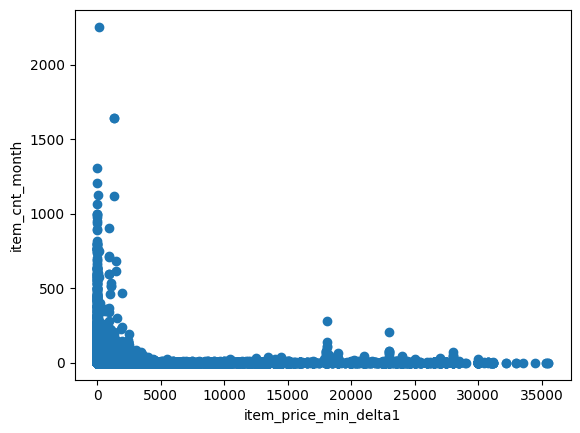

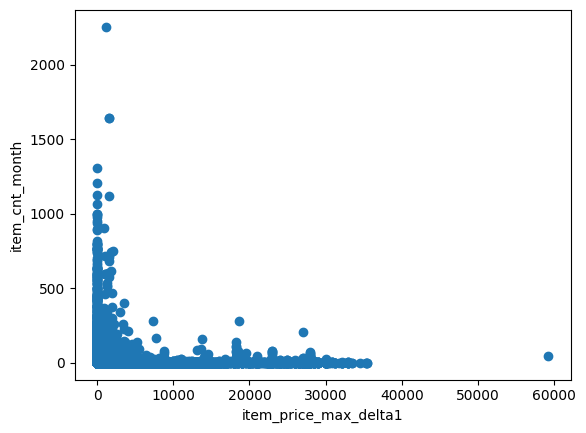

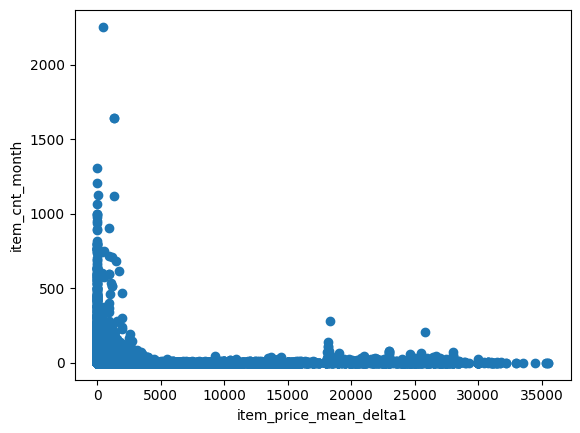

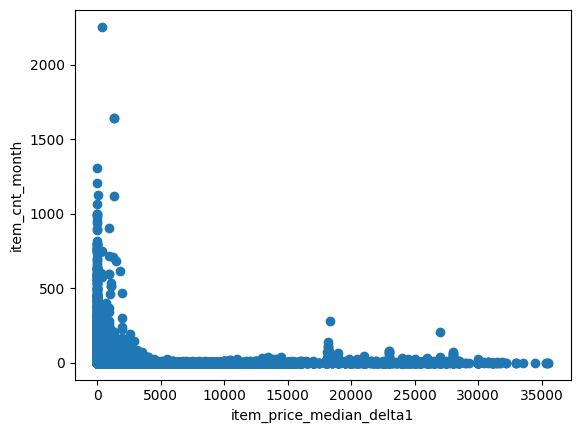

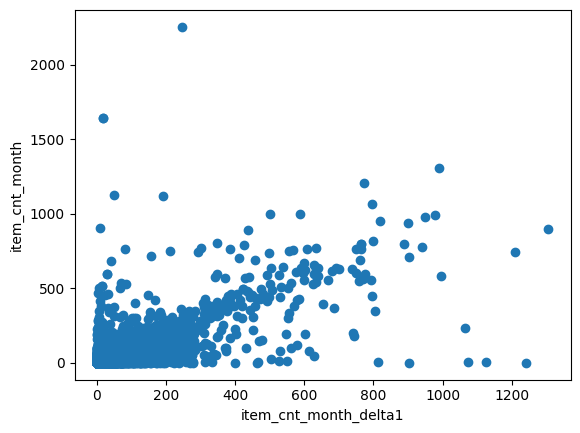

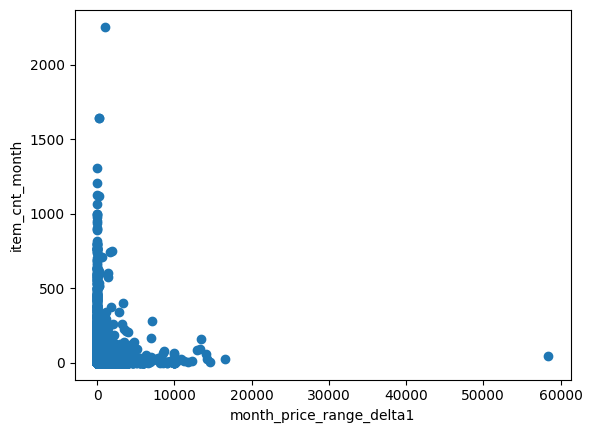

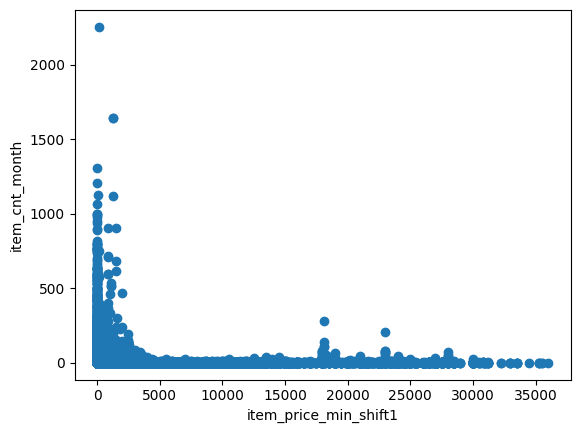

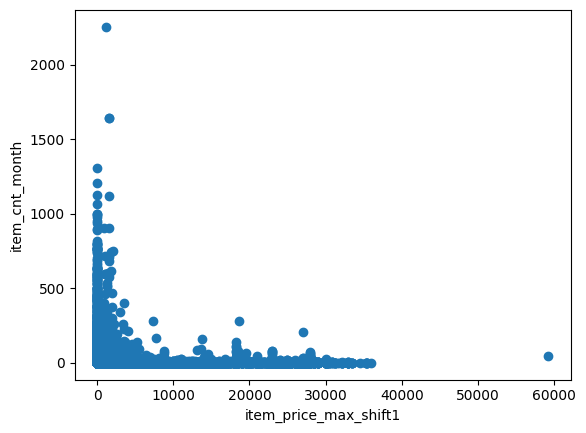

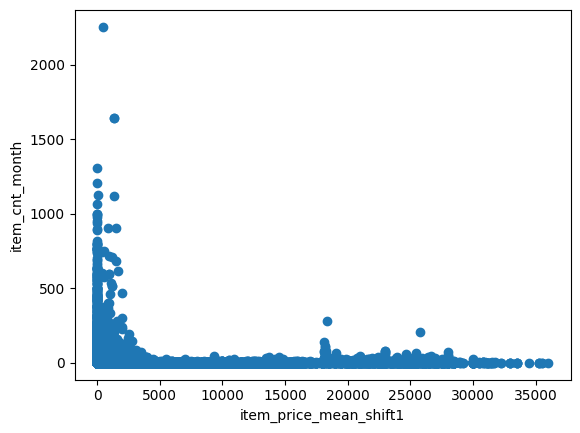

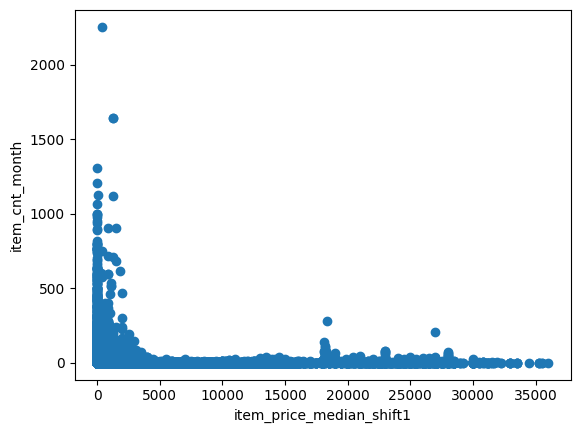

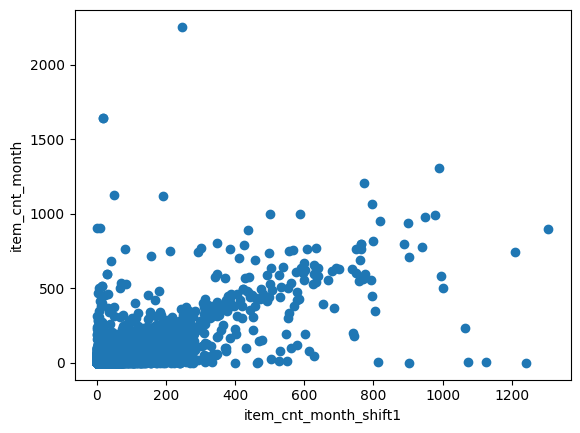

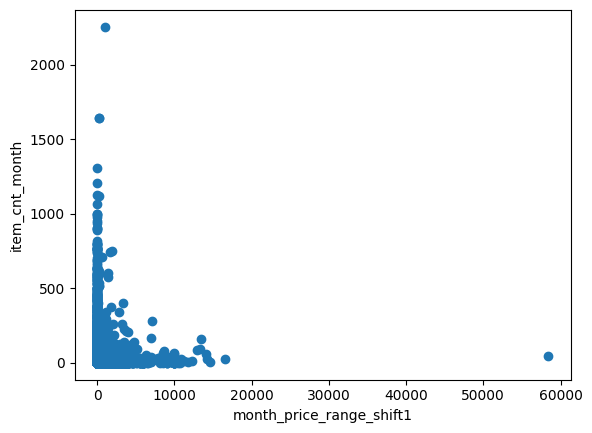

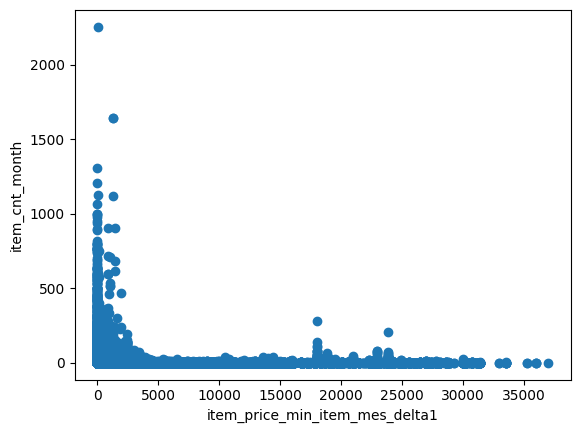

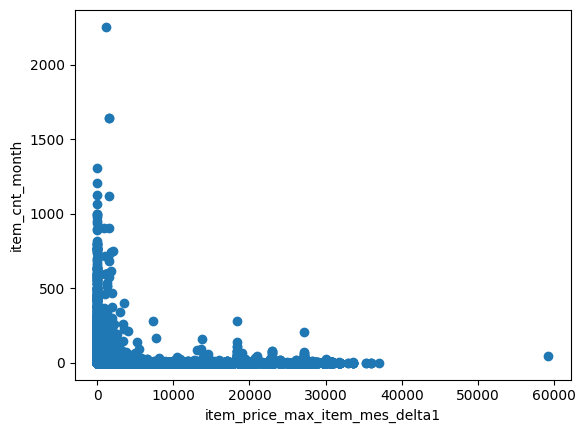

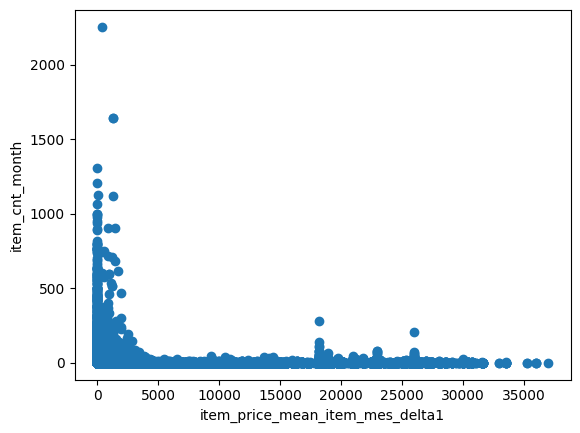

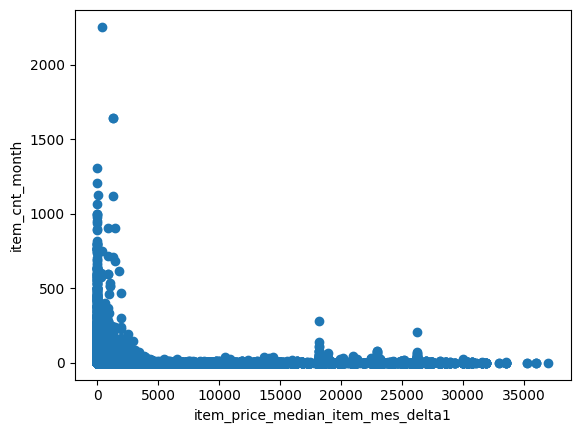

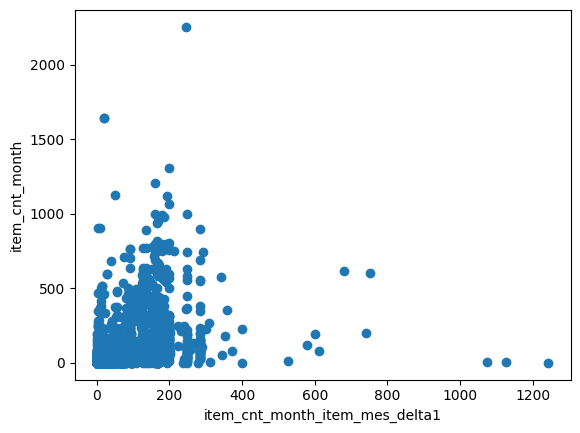

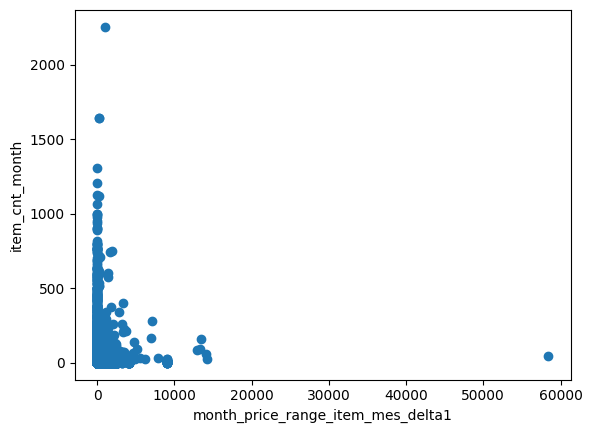

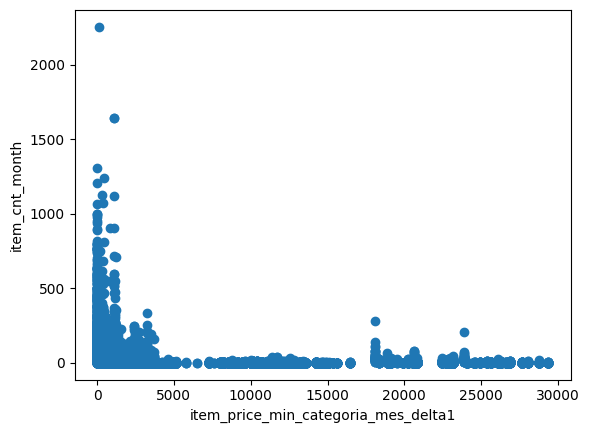

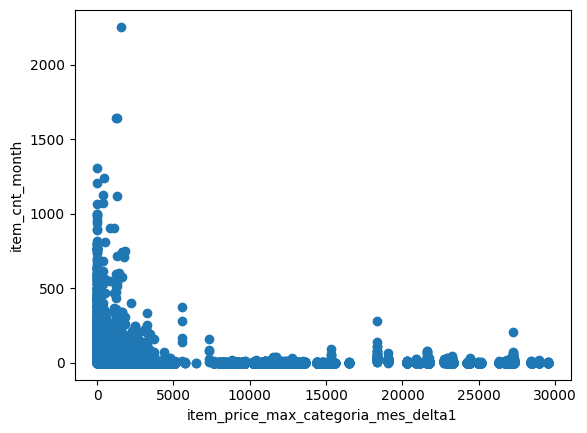

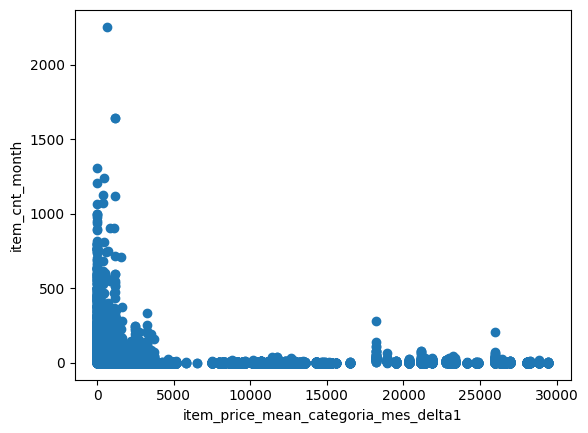

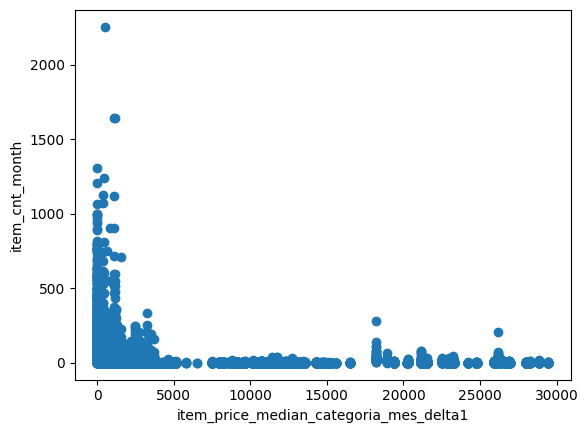

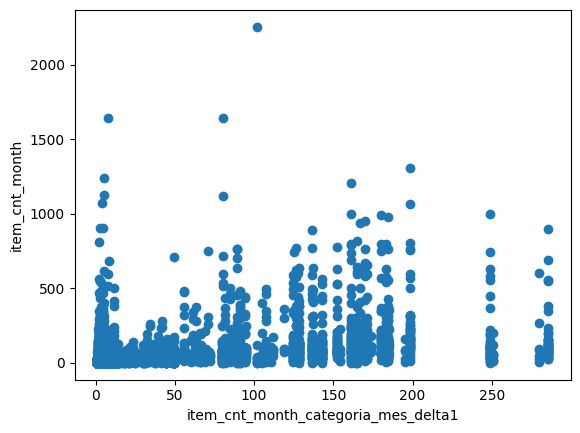

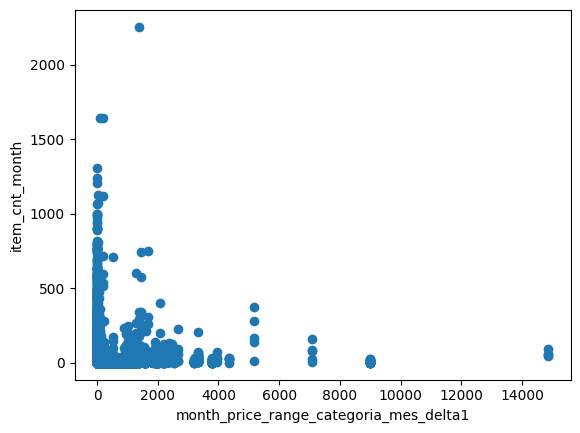

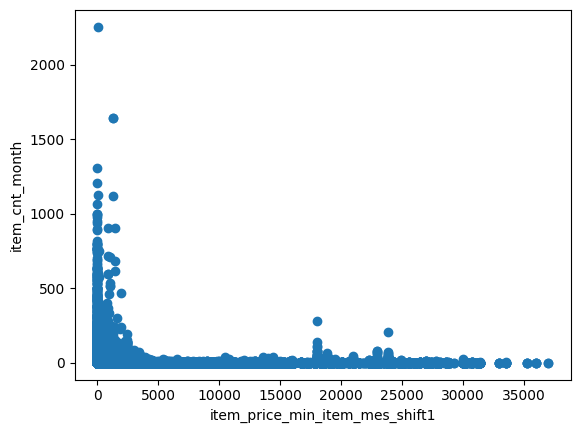

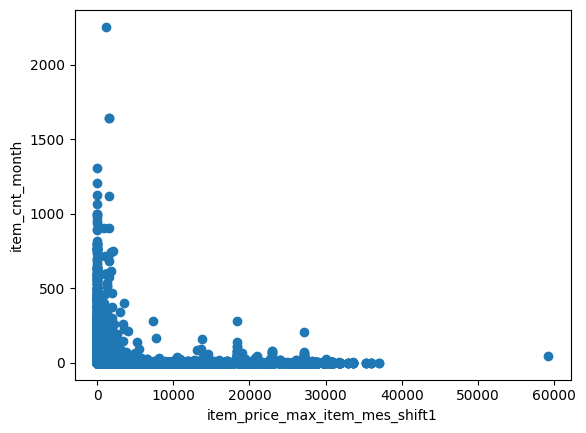

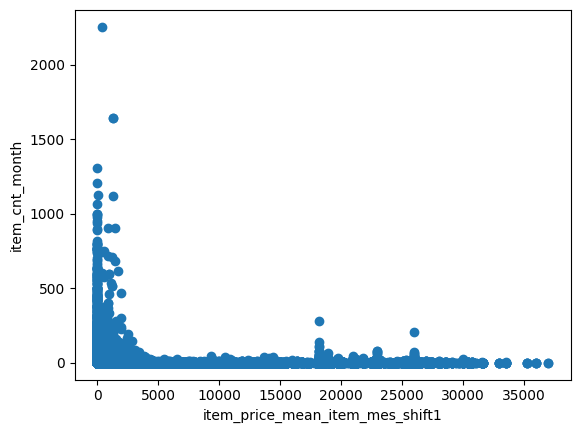

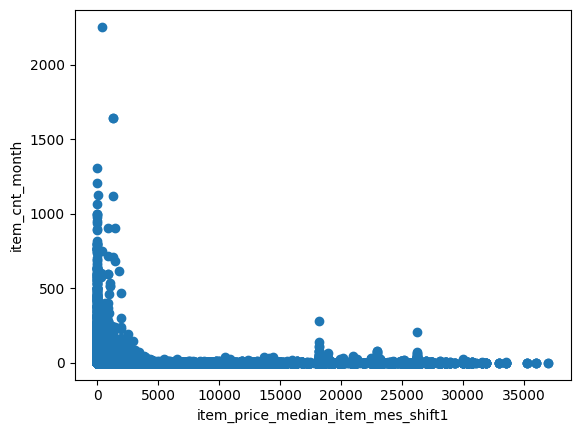

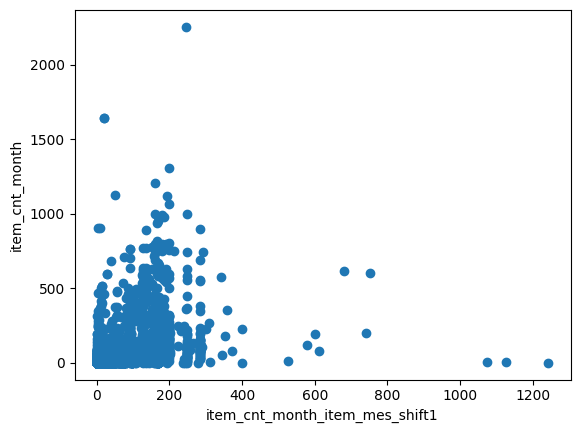

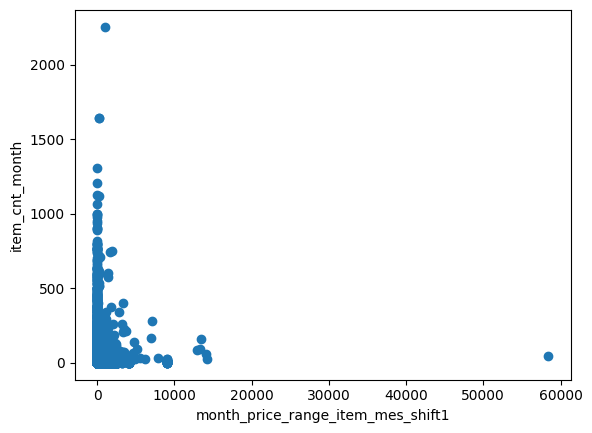

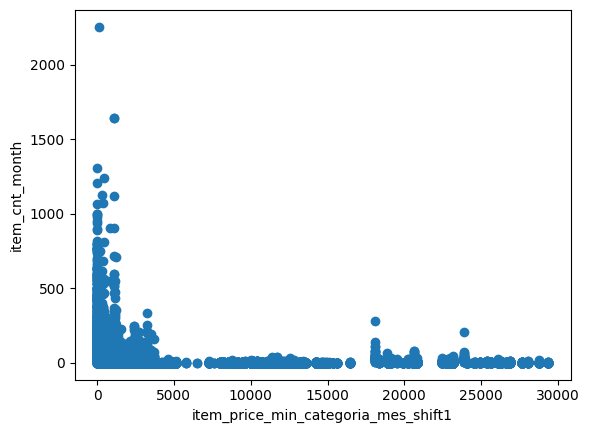

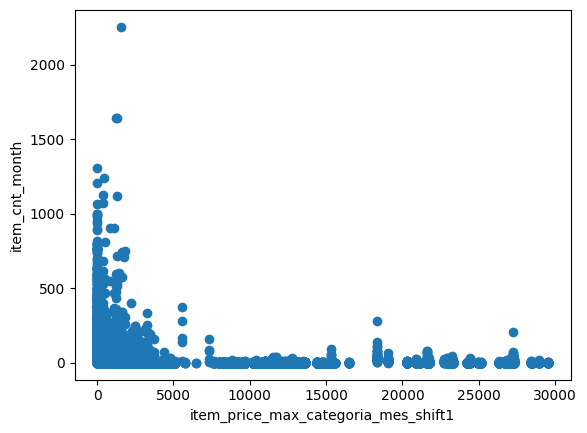

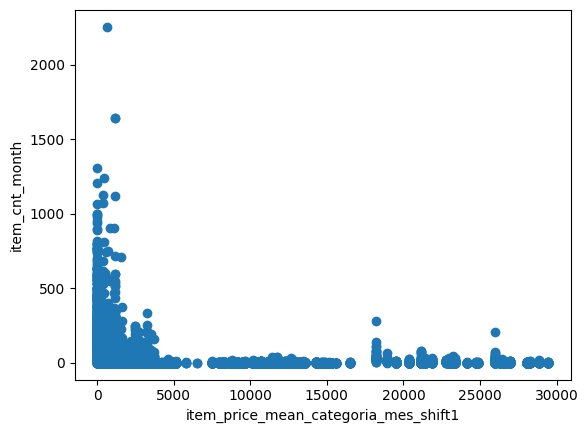

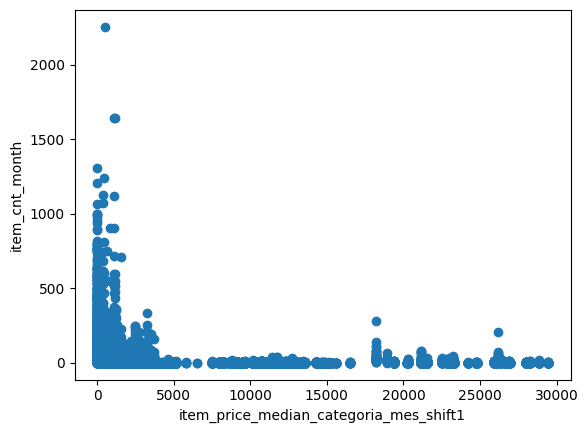

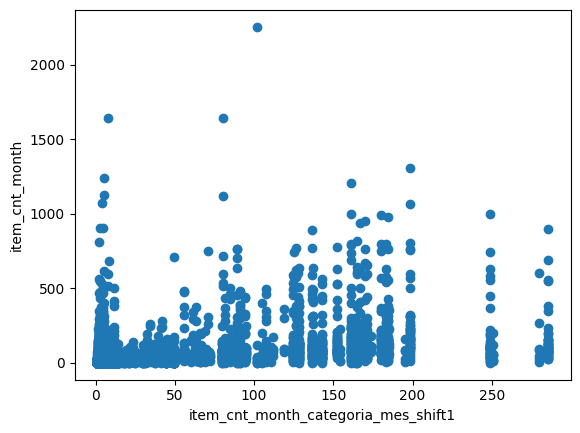

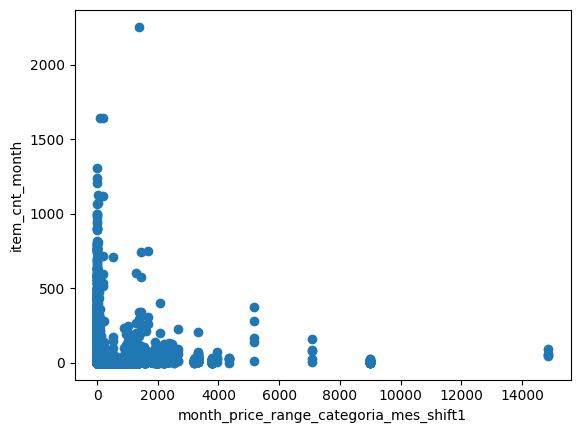

In [54]:
for x_axis in colunas_informacoes_passadas:
    plt.scatter(df_features[x_axis],df_features.item_cnt_month)
    plt.xlabel(x_axis)
    plt.ylabel('item_cnt_month')
    plt.show()

## Mutual information

In [55]:
df_mutual_info = pd.read_csv('dados/mutual_info.csv')

## Removendo features correlacionadas

In [56]:
# em um processo recursivo foram selecionadas uma a uma as 
# features com maior mutual infromation, sendo removidas as
# features com correlação maior que 0.9 com a feature mantida
features_inclusas=['item_cnt_month_item_mes_shift1','item_cnt_month_shift1',
                   'item_price_mean_item_mes_shift1','month_price_range_item_mes_shift1',
                  'item_cnt_month_categoria_mes_shift1','month_price_range_categoria_mes_shift1',
                   'month_price_range_shift1']

In [57]:
features_correlacionadas=['item_cnt_month_item_mes_delta1','item_cnt_month_delta1',
'item_price_mean_item_mes_delta1',
'item_price_median_item_mes_shift1',
'item_price_median_item_mes_delta1',
'item_price_min_item_mes_shift1',
'item_price_min_item_mes_delta1',
'item_price_max_item_mes_shift1',
'item_price_max_item_mes_delta1',
'item_price_mean_delta1',
'item_price_median_delta1',
'item_price_min_delta1',
'item_price_max_delta1',
'item_price_mean_shift1',
'item_price_median_shift1',
'item_price_min_shift1',
'item_price_max_shift1',
'item_price_mean_categoria_mes_shift1',
'item_price_mean_categoria_mes_delta1',
'item_price_median_categoria_mes_shift1',
'item_price_median_categoria_mes_delta1',
'item_price_min_categoria_mes_shift1',
'item_price_min_categoria_mes_delta1',
'item_price_max_categoria_mes_shift1',
'item_price_max_categoria_mes_delta1',
                         'month_price_range_item_mes_delta1',
                         'item_cnt_month_categoria_mes_delta1',
                         'month_price_range_categoria_mes_delta1',
                         'month_price_range_delta1']

In [58]:
df_mutual_info[df_mutual_info.features.isin(features_correlacionadas)==False].sort_values('mutual_info',ascending=False)

,features,mutual_info
28,item_cnt_month_item_mes_shift1,0.127655
10,item_cnt_month_shift1,0.119995
26,item_price_mean_item_mes_shift1,0.110854
29,month_price_range_item_mes_shift1,0.073612
34,item_cnt_month_categoria_mes_shift1,0.054773
35,month_price_range_categoria_mes_shift1,0.047950
11,month_price_range_shift1,0.016483


In [59]:
features_analisadas = list(set(colunas_informacoes_passadas)-set(features_correlacionadas))

In [60]:
df_corr = df_features[features_analisadas].corr()

In [61]:
df_corr['month_price_range_shift1'].sort_values(ascending=False)

month_price_range_shift1                  1.000000
month_price_range_item_mes_shift1         0.768347
month_price_range_categoria_mes_shift1    0.639148
item_price_mean_item_mes_shift1           0.279535
item_cnt_month_item_mes_shift1            0.095331
item_cnt_month_shift1                     0.093137
item_cnt_month_categoria_mes_shift1       0.082050
Name: month_price_range_shift1, dtype: float64

In [62]:
df_features[features_inclusas+['item_price_mean_categoria_mes_shift1']].corr()

,item_cnt_month_item_mes_shift1,item_cnt_month_shift1,item_price_mean_item_mes_shift1,month_price_range_item_mes_shift1,item_cnt_month_categoria_mes_shift1,month_price_range_categoria_mes_shift1,month_price_range_shift1,item_price_mean_categoria_mes_shift1
item_cnt_month_item_mes_shift1,1.000000,0.720496,0.033384,0.127629,0.798032,0.109238,0.095331,0.021678
item_cnt_month_shift1,0.720496,1.000000,0.029352,0.092674,0.574290,0.083938,0.093137,0.018094
item_price_mean_item_mes_shift1,0.033384,0.029352,1.000000,0.298578,0.023767,0.381557,0.279535,0.917495
month_price_range_item_mes_shift1,0.127629,0.092674,0.298578,1.000000,0.107718,0.785632,0.768347,0.318168
item_cnt_month_categoria_mes_shift1,0.798032,0.574290,0.023767,0.107718,1.000000,0.138402,0.082050,0.028802
month_price_range_categoria_mes_shift1,0.109238,0.083938,0.381557,0.785632,0.138402,1.000000,0.639148,0.416780
month_price_range_shift1,0.095331,0.093137,0.279535,0.768347,0.082050,0.639148,1.000000,0.297182
item_price_mean_categoria_mes_shift1,0.021678,0.018094,0.917495,0.318168,0.028802,0.416780,0.297182,1.000000


## Determinando regra de preenchimento de faltantes

In [63]:
df_features[df_features.date_block_num>0][features_inclusas+['item_price_mean_categoria_mes_shift1']].isnull().mean().sort_values(ascending=False)

item_cnt_month_shift1                     0.233602
month_price_range_shift1                  0.233602
item_price_mean_item_mes_shift1           0.070645
item_cnt_month_item_mes_shift1            0.070645
month_price_range_item_mes_shift1         0.070645
item_cnt_month_categoria_mes_shift1       0.000714
month_price_range_categoria_mes_shift1    0.000714
item_price_mean_categoria_mes_shift1      0.000714
dtype: float64

## Aumentando o número de shifts

In [64]:
features_fallback=['item_cnt_month_item_mes',
 'item_cnt_month',
 'item_price_mean_item_mes',
 'month_price_range_item_mes',
 'item_cnt_month_categoria_mes',
 'month_price_range_categoria_mes',
 'month_price_range',
 'item_price_mean_categoria_mes']

In [65]:
df_shifts = df_features.reset_index(drop=True).copy()

In [66]:
features_shift = ['item_cnt_month','month_price_range']

In [67]:
df_shifts = df_shifts.merge(
    df_shifts.groupby(['item_id','shop_id'],as_index=False)[features_shift].shift(2).add_suffix('_shift2'),
    how='left',
    left_index=True,
    right_index=True
)

In [68]:
df_shifts = df_shifts.merge(
    df_shifts.groupby(['item_id','shop_id'],as_index=False)[features_shift].shift(3).add_suffix('_shift3'),
    how='left',
    left_index=True,
    right_index=True
)

In [69]:
df_shifts_part1 = pd.merge_asof(
    left = df_shifts[df_shifts.date_block_num_source.isnull()==False].sort_values('date_block_num_source'),
    right = df_item_mes[['date_block_num','item_id', 
       'item_price_mean','item_cnt_month',
       'month_price_range']].sort_values('date_block_num'),
    left_on = 'date_block_num_source',
    right_on = 'date_block_num',
    left_by = 'item_id',
    right_by = 'item_id',
    suffixes = ('','_item_mes_shift2'),
    allow_exact_matches = False
)

In [70]:
df_shifts = pd.concat([
    df_shifts[df_shifts.date_block_num_source.isnull()],
    df_shifts_part1
])

In [71]:
df_shifts_part1 = pd.merge_asof(
    left = df_shifts[df_shifts.date_block_num_item_mes_shift2.isnull()==False].sort_values('date_block_num_item_mes_shift2'),
    right = df_item_mes[['date_block_num','item_id',
       'item_price_mean', 'item_cnt_month',
       'month_price_range']].sort_values('date_block_num'),
    left_on = 'date_block_num_item_mes_shift2',
    right_on = 'date_block_num',
    left_by = 'item_id',
    right_by = 'item_id',
    suffixes = ('','_item_mes_shift3'),
    allow_exact_matches = False
)

In [72]:
df_shifts.shape

(1608226, 58)

In [73]:
df_shifts = pd.concat([
    df_shifts[df_shifts.date_block_num_item_mes_shift2.isnull()],
    df_shifts_part1
])

In [74]:
df_shifts_part1 = pd.merge_asof(
    left = df_shifts[df_shifts.date_block_num_source_categoria_mes_shift1.isnull()==False].sort_values('date_block_num_source_categoria_mes_shift1'),
    right = df_categoria_mes[['date_block_num','item_category_id',
       'item_price_mean','item_cnt_month',
       'month_price_range']].sort_values('date_block_num'),
    left_on = 'date_block_num_source_categoria_mes_shift1',
    right_on = 'date_block_num',
    left_by = 'item_category_id',
    right_by = 'item_category_id',
    suffixes = ('','_categoria_mes_shift2'),
    allow_exact_matches = False
)

In [75]:
df_shifts = pd.concat([
    df_shifts[df_shifts.date_block_num_source_categoria_mes_shift1.isnull()],
    df_shifts_part1
])

In [78]:
df_shifts_part1 = pd.merge_asof(
    left = df_shifts[df_shifts.date_block_num_categoria_mes_shift2.isnull()==False].sort_values('date_block_num_categoria_mes_shift2'),
    right = df_categoria_mes[['date_block_num','item_category_id',
       'item_price_mean', 'item_cnt_month',
       'month_price_range']].sort_values('date_block_num'),
    left_on = 'date_block_num_categoria_mes_shift2',
    right_on = 'date_block_num',
    left_by = 'item_category_id',
    right_by = 'item_category_id',
    suffixes = ('','_categoria_mes_shift3'),
    allow_exact_matches = False
)

In [79]:
df_shifts = pd.concat([
    df_shifts[df_shifts.date_block_num_categoria_mes_shift2.isnull()],
    df_shifts_part1
])

In [81]:
df_shifts.to_csv('dados/dataframe_features.csv')